[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana5/ComparacionesUsuarios_Coseno.ipynb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install surprise

### Introducción

En este ejemplo utilizaremos los datos de la [competencia de Netflix](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data?select=combined_data_1.txt) en Kaggle. El objetivo de esta competencia era mejorar el algoritmo de recomendación 10%. Nosotros no seremos tan avariciosos. En esta primer sesión exploraremos comparaciones básicas que podríamos utilizar. Para la segunda sesión los objetivos serán: 

*   Análisis exploratorio de matriz y por qué es dispersa.
*   Implementación de Singular Value Decomposition.
*   Implementación de un modelo de sistema de recomendación de filtro colaborativo.
*   Generar la predicción de recomendaciones con buen resultado y no.

In [ ]:
import math 
import re 

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.sparse import csr_matrix
# from surprise import Reader, Dataset, SVD   # Simple Python RecommendatIon System Engine
#from surprise.model_selection import cross_validate

En este caso cargar los datos nos llevará un rato por la gran cantidad de registros que tenemos. Sólo cargaremos un archivo, pero la competencia tiene un total de 3 archivos.

In [ ]:
# Recuerde, pueden conseguir la dirección del archivo en su Drive y copiarla en la dirección
df = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana5/combined_data_1.txt', 
                 names=['Client_Id', 'Rating', 'Date'], low_memory=True, nrows=12*(10**6))

In [ ]:
df

,Client_Id,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
11999995,2000580,2.0,2002-10-13
11999996,1809161,4.0,2003-06-19
11999997,1547886,2.0,2002-10-27
11999998,2905,2.0,2002-05-18


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000000 entries, 0 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  object 
 1   Rating     float64
 2   Date       object 
dtypes: float64(1), object(2)
memory usage: 274.7+ MB


In [ ]:
# Revisamos los nulos. 

df.isnull().sum()

Client_Id       0
Rating       2340
Date         2340
dtype: int64

En este caso los registros que tenemos con valores nulos corresponden al Id de las películas. Si observamos los registros nulos están ordenados del 1 al 2,340. 

In [ ]:
df[df['Rating'].isnull()].shape

(2340, 3)

In [ ]:
df[df['Rating'].isnull()]

,Client_Id,Rating,Date
0,1:,NaN,NaN
548,2:,NaN,NaN
694,3:,NaN,NaN
2707,4:,NaN,NaN
2850,5:,NaN,NaN
...,...,...,...
11987100,2336:,NaN,NaN
11987192,2337:,NaN,NaN
11989727,2338:,NaN,NaN
11993647,2339:,NaN,NaN


In [ ]:
movies = df['Rating'].isnull().sum()
print(f'Este es el número de películas que tenemos en este archivo: {movies}')

Este es el número de películas que tenemos en este archivo: 2340


In [ ]:
reviews = df[df['Rating'].isnull()==False]['Client_Id'].count()
print(f'Este es el número de calificaciones: {reviews}')

Este es el número de calificaciones: 11997660


In [ ]:
users = df['Client_Id'].nunique() - movies
print(f'Esta es la cantidad de usuarios que tenemos: {users}')

Esta es la cantidad de usuarios que tenemos: 455716


En este caso no estaremos trabajando con las fechas. Por lo tanto haremos un subconjunto de nuestro DF original. 

In [ ]:
df_sub = df[['Client_Id', 'Rating']]

**¿Cómo podriamos incluir las fechas en un sistema de clasificación?**

- Horarios de recomendacion (Carlos)
- Comparacion con fecha de estreno(Javier)
- Depreciacion de calificación en el tiempo (Max)


Ahora observemos como se distribuye la frecuencia para la columna de rating.

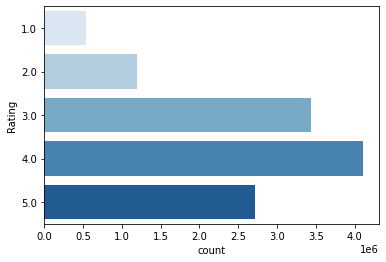

In [ ]:
sns.countplot(y=df_sub['Rating'], orient='v', palette='Blues');

In [ ]:
df_sub['Rating'].value_counts() / df_sub['Rating'].count() * 100

4.0    34.239052
3.0    28.693037
5.0    22.638765
2.0     9.925744
1.0     4.503403
Name: Rating, dtype: float64

La mayor parte de nuestros valores se distribuyen en los ratings de 3 y 4 estrellas. La mayoría de los rating son positivos.

### Hora de la limpieza

En este caso los valores nulos que tenemos hacen referencia a **Id** de 'clientes' con rating vacíos. En realidad esta información es el **Id** de la película. Lo que debemos hacer ahora es quitar estos registros y añadir los **Id's** de película como una nueva columna. 

In [ ]:
# Generamos una serie con valores booleanos. Donde Verdadero será igual al lugar
# donde hay un Id de película.
pd.isnull(df_sub['Rating'][:100])

0      True
1     False
2     False
3     False
4     False
      ...  
95    False
96    False
97    False
98    False
99    False
Name: Rating, Length: 100, dtype: bool

In [ ]:
# Colocamos la serie como un DataFrame
df_null = pd.DataFrame(pd.isnull(df_sub['Rating']))
df_null.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [ ]:
# Obtenemos sólo los registros de películas junto con índice hasta donde llega 
# los rating para esa película.
df_null = df_null[df_null['Rating'] == True]
df_null.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [ ]:
# Colocamos el índice como columna para tener la ubicación para hasta donde repe-
# tir nuestros valores de Id para esa película.
df_null = df_null.reset_index()
df_null.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [ ]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

# En esta celda para saber cómo hace el proceso imprimo los distintos pasos.
for i, j in zip(df_null['index'][1:3], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  print(i, j)
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  print(temporary)
  print(temporary.shape)
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista. 
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.
  print('---'*15)
  print(movie_id_array)
  print(movie_id)
  print('---'*30)
  print('---'*30)



548 0
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
movie_id_array = [] # Generamos una lista vacía donde colocaremos el Id de la película las veces que se repita.
movie_id = 1 # Inicializamos un contador

# En esta celda para saber cómo hace el proceso imprimo los distintos pasos.
for i, j in zip(df_null['index'][1:], df_null['index'][:-1]): # Iteramos sobre los valores de la columna 'index'
                                                               # empezando por el valor n+1 y en segundo lugar desde n hasta el penúltimo valor de la serie.
  temporary = np.full((1, i-j-1), fill_value=movie_id) # Creamos una matriz llena de valores con la forma de 1x(la diferencia del valor (n+1)-n-1).
                                                       # Esto nos da una matriz llena con el Id repetido el número de reviews para esa película.
  movie_id_array = np.append(movie_id_array, temporary) # Lo añadimos a una lista. 
  movie_id += 1                                         # Aumentamos el Id para la siguiente película.

In [ ]:
movie_id

2340

In [ ]:
# Generamos los Id's para la última película que no está contemplada en nuestro loop.
last_movie = np.full((1, len(df_sub) - df_null.iloc[-1, 0] - 1), movie_id)
movie_id_array = np.append(movie_id_array, last_movie)

In [ ]:
movie_id_array.shape # la cantidad de Id's corresponde con la cantidad de películas.

(11997660,)

In [ ]:
movie_id_array

array([1.00e+00, 1.00e+00, 1.00e+00, ..., 2.34e+03, 2.34e+03, 2.34e+03])

Ahora para tener todo en orden es necesario que quitemos los registros nulos de nuestro df y añadamos los Id's que generamos.

In [ ]:
df_clean = df_sub[pd.notnull(df_sub['Rating'])]

In [ ]:
df_clean

,Client_Id,Rating
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
...,...,...
11999995,2000580,2.0
11999996,1809161,4.0
11999997,1547886,2.0
11999998,2905,2.0


In [ ]:
df_clean['Movie_Id'] = movie_id_array.astype('int16') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_clean['Client_Id'] = df_clean['Client_Id'].astype('int32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_clean.head()

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [ ]:
df_clean.tail()

,Client_Id,Rating,Movie_Id
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340
11999999,1876520,1.0,2340


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11997660 entries, 1 to 11999999
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Client_Id  int32  
 1   Rating     float64
 2   Movie_Id   int16  
dtypes: float64(1), int16(1), int32(1)
memory usage: 251.7 MB


### Convirtiendo a matriz dispersa o generando nuestra tabla Usuario-Item

In [ ]:
df_clean

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
11999995,2000580,2.0,2340
11999996,1809161,4.0,2340
11999997,1547886,2.0,2340
11999998,2905,2.0,2340


In [ ]:
df_short = df_clean[df_clean['Movie_Id']<1000]

In [ ]:
df_short

,Client_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
5010433,1100542,2.0,999
5010434,1033266,3.0,999
5010435,2205373,1.0,999
5010436,234275,3.0,999


In [ ]:
# Por limitantes de la ramm, no podemos crearlo, pero en local o usando otras herramientas, podrían 
%%time
pivot_user_item = df_short.pivot(index='Client_Id', columns='Movie_Id', values='Rating').fillna(2.5)

CPU times: user 18 s, sys: 1.73 s, total: 19.7 s
Wall time: 21.9 s


In [ ]:
pivot_user_item.head()

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
Client_Id,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pivot_copy = pivot_user_item.copy()

In [ ]:
for i in range(1,9):
  pivot_copy = pivot_copy[pivot_copy[i] != 0]

In [ ]:
pivot_copy

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
Client_Id,,,,,,,,,,,,,,,,,,,,,
305344,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,3.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0
387418,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,0.0,3.0
1664010,5.0,4.0,5.0,3.0,5.0,4.0,3.0,4.0,3.0,4.0,...,5.0,5.0,5.0,5.0,0.0,2.0,5.0,4.0,0.0,5.0
2118461,5.0,4.0,4.0,3.0,5.0,4.0,3.0,3.0,0.0,3.0,...,4.0,5.0,5.0,0.0,5.0,0.0,4.0,4.0,0.0,4.0
2439493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


## Pequeñas Pruebas

In [ ]:
pivot_copy = pivot_copy[[1,2,3,4,5,6,7,8,9]]
pivot_copy

Movie_Id,1,2,3,4,5,6,7,8,9
Client_Id,,,,,,,,,
305344,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
387418,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0
1664010,5.0,4.0,5.0,3.0,5.0,4.0,3.0,4.0,3.0
2118461,5.0,4.0,4.0,3.0,5.0,4.0,3.0,3.0,0.0
2439493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


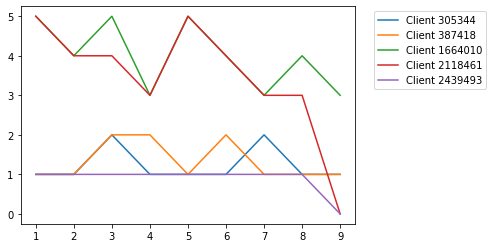

In [ ]:
plt.plot(range(1,10), pivot_copy.loc[305344,:])
plt.plot(range(1,10), pivot_copy.loc[387418,:])
plt.plot(range(1,10), pivot_copy.loc[1664010,:])
plt.plot(range(1,10), pivot_copy.loc[2118461,:])
plt.plot(range(1,10), pivot_copy.loc[2439493,:])

plt.legend(['Client 305344', 'Client 387418', 'Client 1664010', 'Client 2118461', 'Client 2439493'], bbox_to_anchor=(1.04,1), loc="upper left")

## Comparaciones con medida Coseno

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

Se obtiene de la siguiente manera:

$$ S_C (P,Q):= \cos(\theta) = {P \cdot Q \over \|P\| \|Q\|} = \frac{ \sum\limits_{i=1}^{n}{p_i  q_i} }{ \sqrt{\sum\limits_{i=1}^{n}{p_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{q_i^2}} }$$

Donde $\theta$ es el angulo entre los vectores $P$ y $Q$.

In [ ]:
help(cosine_similarity)

Help on function cosine_similarity in module sklearn.metrics.pairwise:

cosine_similarity(X, Y=None, dense_output=True)
    Compute cosine similarity between samples in X and Y.
    
    Cosine similarity, or the cosine kernel, computes similarity as the
    normalized dot product of X and Y:
    
        K(X, Y) = <X, Y> / (||X||*||Y||)
    
    On L2-normalized data, this function is equivalent to linear_kernel.
    
    Read more in the :ref:`User Guide <cosine_similarity>`.
    
    Parameters
    ----------
    X : {ndarray, sparse matrix} of shape (n_samples_X, n_features)
        Input data.
    
    Y : {ndarray, sparse matrix} of shape (n_samples_Y, n_features),             default=None
        Input data. If ``None``, the output will be the pairwise
        similarities between all samples in ``X``.
    
    dense_output : bool, default=True
        Whether to return dense output even when the input is sparse. If
        ``False``, the output is sparse if both input arrays ar

Ejemplificación:

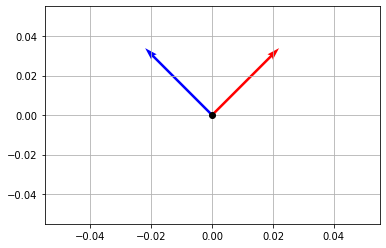

In [ ]:
# Comparemos los vectores (1,1) y (-1,1)
V = np.array([[1,1], [-1,1]])
origin = np.array([[0, 0],[0, 0]]) # punto origen

plt.plot(0,0,'ok')
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=5)
plt.grid()
plt.show()

In [ ]:
# La restaremos al 1 por la forma en que lo calcula el módulo que estamos utilizando (scipy)
cosine_similarity([np.array([1,1]), np.array([-1,1])])

array([[1.00000000e+00, 2.23711432e-17],
       [2.23711432e-17, 1.00000000e+00]])

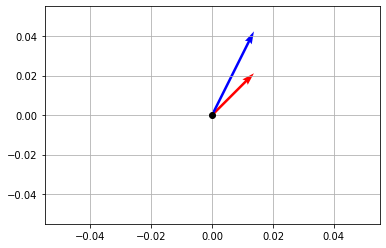

In [ ]:
# Comparemos los vectores (1,1) y (1,2)
V = np.array([[1,1], [1,2]])
origin = np.array([[0, 0],[0, 0]]) # punto origen

plt.plot(0,0,'ok')
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=8)
plt.grid()
plt.show()

In [ ]:
cosine_similarity([np.array([1,1]), np.array([1,2])])

array([[1.       , 0.9486833],
       [0.9486833, 1.       ]])

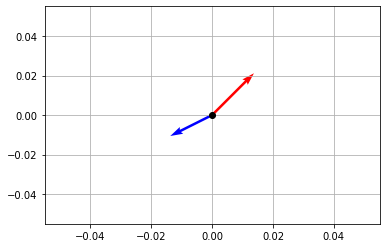

In [ ]:
# Comparemos los vectores (1,1), (1, -0.5)
V = np.array([[1,1], [-1,-0.5]])
origin = np.array([[0, 0],[0, 0]]) # punto origen

plt.plot(0,0,'ok')
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=8)
plt.grid()
plt.show()

In [ ]:
cosine_similarity([np.array([1,1]), np.array([-1,-.5])])

array([[ 1.       , -0.9486833],
       [-0.9486833,  1.       ]])

# Usemos la similitud coseno con nuestros datos:

In [ ]:
# Recordemos los datos que nos quedaron tras un filtro muy estricto
pivot_copy

Movie_Id,1,2,3,4,5,6,7,8,9
Client_Id,,,,,,,,,
305344,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
387418,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0
1664010,5.0,4.0,5.0,3.0,5.0,4.0,3.0,4.0,3.0
2118461,5.0,4.0,4.0,3.0,5.0,4.0,3.0,3.0,0.0
2439493,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [ ]:
de_1_a_2 = cosine_similarity([pivot_copy.loc[305344,:], pivot_copy.loc[387418,:]])
de_1_a_2

array([[1.        , 0.90358411],
       [0.90358411, 1.        ]])

In [ ]:
de_1_a_4 = cosine_similarity([pivot_copy.loc[305344,:], pivot_copy.loc[2118461,:]])
de_1_a_4

array([[ 1.        , -0.52049568],
       [-0.52049568,  1.        ]])

In [ ]:
de_3_a_4 = cosine_similarity([pivot_copy.loc[1664010,:], pivot_copy.loc[2118461,:]])
de_3_a_4

array([[1.        , 0.79047619],
       [0.79047619, 1.        ]])

In [ ]:
pivot_copy = pivot_copy - 2.5

In [ ]:
pivot_copy

Movie_Id,1,2,3,4,5,6,7,8,9
Client_Id,,,,,,,,,
305344,-1.5,-1.5,-0.5,-1.5,-1.5,-1.5,-0.5,-1.5,-1.5
387418,-1.5,-1.5,-0.5,-0.5,-1.5,-0.5,-1.5,-1.5,-1.5
1664010,2.5,1.5,2.5,0.5,2.5,1.5,0.5,1.5,0.5
2118461,2.5,1.5,1.5,0.5,2.5,1.5,0.5,0.5,-2.5
2439493,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-1.5,-2.5
